# Montando o drive

In [1]:
# Montando o drive onde estão os datasets a serem baixados.

from google.colab import drive # Importando a biblioteca que sera utilizada para acessar o drive.
drive.mount('/content/drive') # Montando um drive, clique no link e de a permissão para acessar o drive.

Mounted at /content/drive


# Imports

In [2]:
import numpy as np # Lidar com ndarrays.
from matplotlib import pyplot as plt # Para plots.
import cv2 as cv # OpenCV (for image processing).
import tensorflow as tf # Para machine learning.
import os # Lidar com diretorios.
import PIL # pillow (for image processing).
from ipywidgets import interact # Para visualizar as predições.

%cd "/content/drive/MyDrive/Packages" # Indo no diretorio onde estão nossos packages.

# Conjunto de funções desenvolvidas pelos alunos
# from package_alexandre.classes_funcoes import plot_images # As funções utilizadas foram passadas para este notebook e a importação do package não é mais necessaria.  
# from package_vinicius import modulo_vinicius # As funções utilizadas foram passadas para este notebook e a importação do package não é mais necessaria.

print('Pillow Version:', PIL.__version__)

"""gpu = !nvidia-smi -L
print('Not using GPU' if 'failed' in gpu[0] else gpu[0].split(' (')[0])"""

gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

/content/drive/MyDrive/Packages
Pillow Version: 7.1.2
Tue Sep 28 00:04:36 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.63.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    28W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                  

In [3]:
# Funções para carregar imagens e diretorios:

# Loading all data.
# 1280x720.
# load all images in a directory.
from os import listdir
from matplotlib import image
# load all raw images in a directory.
rgb_rawlight = list()
semantic = list()

def load_image(dir):

  """
  Loads masks image.
  """

  img = image.imread(dir)
  return img

def load_rgb_image(dir):

  """
  Loads rgb image (Input).
  """

  img = cv.imread(dir)
  img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
  return img

def load_imagens(dir_, max = None):

  """
  dir_ -> Main directory of images. (ex: //folder//my_files_to_load)).
  max -> Num of images to load. (If nome, loads all.)
  """

  img_list = []
  if max == None:
    max = len(listdir(dir_))
  for filename in sorted(listdir(dir_))[0:max]:
    img_data = image.imread(dir_ + '/' + filename) # load image.
    img_list.append(img_data) # store loaded image.
    #print('> loaded %s %s' % (filename, img_data.shape)).
  print(f'{len(img_list)} images successful loaded.')
  return img_list

def load_files_from_dir(main_dir, max_ = None):
  """
  Load full directories of all files in main_dir.
  """
  if max_ is None:
    max_ = len(listdir(main_dir))
  else:
    pass
  
  dir_list = [os.path.join(main_dir,filename) for filename in sorted(listdir(main_dir))[:max_]]

  print(f'{len(dir_list)} directories successful loaded.')
  return dir_list

## Dictionaries

In [4]:
# Dicionario de classes para consulta.  

class_dict = {
    (0, 0, 0):       0, #JANELAS,PORTAS ABERTAS **** 
    (174, 199, 232): 1, # PAREDE ********
    (152, 223, 138): 2, # CHÃO ***
    (31, 119, 180):  3, # ARMARIO ********
    (255, 187, 120): 4, # CAMA
    (188, 189, 34):  5, # CADEIRA
    (140, 86, 75):   6, # SOFA
    (255, 152, 150): 7, # MESA
    (214, 39, 40):   8, # PORTA ********
    (197, 176, 213): 9, # JANELA E BORDA DA JANELA  ********
    (148, 103, 189): 39,# (10)NTEM
    (196, 156, 148): 1, # (11)PINTURAS E QUADROS -> (1)PAREDE ***
    (23, 190, 207):  7, # (12)MESINHA -> (7)MESA
    (178, 76, 76):   39,# (13)NTEM
    (247, 182, 210): 39,# (14)KIT MESA ESCRITORIO CADEIRA BAGUNÇA -> (39)OUTROS
    (66, 188, 102):  39,# (15)VAZOS E PLANTAS ALEATORIAS -> (39)OUTROS
    (219, 219, 141): 1, # (16)CORTINAS -> (1)PAREDE ********
    (140, 57, 197):  7, # (17)CRIADO MUDO/ ESPELHOS -> (7)TABLE
    (202, 185, 52):  4, # (18)ALMOFADAS -> (4)CAMA **
    (51, 176, 203):  1, # (19)ESPELHOS -> (1)PAREDE
    (200, 54, 131):  39,# (20)NTEM
    (92, 193, 61):   39,# (21)NTEM
    (78, 71, 183):   22,# TETO ********
    (172, 114, 82):  39,# (23)NTEM
    (255, 127, 14):  3, # (24)REFRIGERADOR -> (3)ARMARIO
    (91, 163, 138):  1, # (25)TV -> (1)PAREDE
    (153, 98, 156):  39,# (26)NTEM 
    (140, 153, 101): 39,# (27)NTEM
    (158, 218, 229): 39,# (28)CURTINA DE BANHEIRO NTEM
    (100, 125, 154): 1, # (29) BANNER/QUADROS/PLACAS -> (1)PAREDE
    (178, 127, 135): 39,# (30)NTEM
    (120, 185, 128): 39,# (31)NTEM
    (146, 111, 194): 7, # (32)BIDE -> (7)MESA
    (44, 160, 44):   39,# (33)PRIVADA -> (39)OUTROS
    (112, 128, 144): 1, # (34)ESPELHOS E PIAS -> (1)PAREDE
    (96, 207, 209):  22,# (35)LUZES/LUSTRES/LEDS -> (22)TETO
    (227, 119, 194): 39,# (36)BANHEIRA -> (39)OUTROS
    (213, 92, 176):  39,# (37)NTEM
    (94, 106, 211):  1, # (38)ARMAÇOES E BOXES -> (1)PAREDE ********
    (82, 84, 163):   39,# (39)OUTROS
    (100, 85, 144):  1  # (40) BORDAS DE COISAS/AMAÇÕES -> (1)PAREDE ******** 
    }

#Our classes: 1,2,22 (3 classes) convertidas para 0,1,2.
# Todas as outras classes foram juntadas com a classe parede (1).

reversed_clases_dict = {value : key for (key, value) in class_dict.items()}

# Carregando os datasets para o ambiente do colab

## 3classes

Floor: 1  <br> 
Roof: 2 <br>
Wall: 0

In [5]:
# Baixando o arquivo rar que contem o dataset para o colab. 
%cp -r /content/drive/MyDrive/Datasets/3classes_1517 /content/

%cd "/content/3classes_1517" 

/content/3classes_1517


In [6]:
# Descompactando os arquivos.

%cd "/content/3classes_1517"

!unzip Dataset_wall_floor_roof_1517.zip

A saída de streaming foi truncada nas últimas 5000 linhas.
  inflating: Dataset_empty_15_17_rgb_&_wall_floor_roof/semantic_resized_wall_floor_roof1517/scene_03113-370-2-semantic.png  
  inflating: Dataset_empty_15_17_rgb_&_wall_floor_roof/semantic_resized_wall_floor_roof1517/scene_03055-446715-2-semantic.png  
  inflating: Dataset_empty_15_17_rgb_&_wall_floor_roof/semantic_resized_wall_floor_roof1517/scene_03073-367-2-semantic.png  
  inflating: Dataset_empty_15_17_rgb_&_wall_floor_roof/semantic_resized_wall_floor_roof1517/scene_03061-1783-2-semantic.png  
  inflating: Dataset_empty_15_17_rgb_&_wall_floor_roof/semantic_resized_wall_floor_roof1517/scene_03462-169958-0-semantic.png  
  inflating: Dataset_empty_15_17_rgb_&_wall_floor_roof/semantic_resized_wall_floor_roof1517/scene_03042-974194-1-semantic.png  
  inflating: Dataset_empty_15_17_rgb_&_wall_floor_roof/semantic_resized_wall_floor_roof1517/scene_03199-470733-0-semantic.png  
  inflating: Dataset_empty_15_17_rgb_&_wall_floor_roo

In [7]:
# Carregando os diretorios das imagens rgb e mascara.

direc = "/content/3classes_1517/Dataset_empty_15_17_rgb_&_wall_floor_roof/semantic_resized_wall_floor_roof1517"

y_data = load_files_from_dir(direc, max_ = None)

direc = "/content/3classes_1517/Dataset_empty_15_17_rgb_&_wall_floor_roof/rgb_resized1517"

x_data = load_files_from_dir(direc, max_ = None)

6515 directories successful loaded.
6515 directories successful loaded.


## Separação do dataset e visualização

In [8]:
# Divide o dataset em treinamento, validação e testes.

from sklearn.model_selection import train_test_split

x_train , x_val, y_train, y_val = train_test_split(x_data, y_data, train_size = 0.9, random_state=0)
x_train , x_test, y_train, y_test = train_test_split(x_train, y_train, train_size = 0.8888, random_state=0)

print('train: ',len(x_train) , len(y_train))
print('val: ',len(x_val) , len(y_val))
print('test: ',len(x_test) , len(y_test))

train:  5211 5211
val:  652 652
test:  652 652


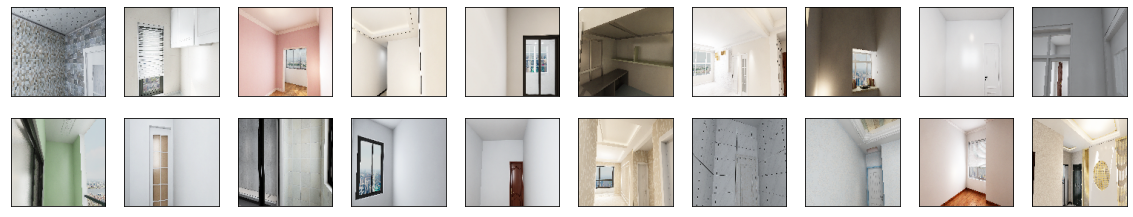

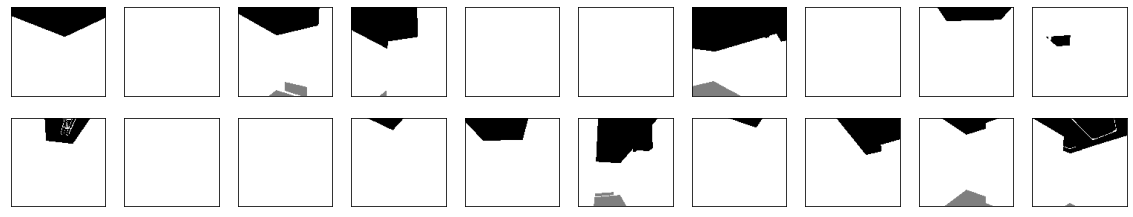

In [9]:
# Visualiza o dataset.

seed = np.random.randint(0,99999) # Para carregar imagens aleatorias.

np.random.seed(seed=seed)

plt.figure(figsize=(20,20))
for i in range(20):
    plt.subplot(10,10,i+1)
    rand = np.random.randint(0,len(x_train)-1)
    plt.imshow(load_rgb_image(x_train[rand]), cmap=plt.cm.gray_r);
    plt.xticks([]);
    plt.yticks([]);

np.random.seed(seed=seed)

plt.figure(figsize=(20,20))
for i in range(20):
    plt.subplot(10,10,i+1)
    plt.imshow(load_image(y_train[np.random.randint(0,len(y_train)-1)]), cmap=plt.cm.gray_r);
    plt.xticks([]);
    plt.yticks([]);


In [10]:
# Checagens.

print('X shape',(load_image(x_train[i]).shape))
print('Y shape',(load_image(y_train[i]).shape))
print(" ")
print(" ")
#print('X values check',np.unique(load_image(x_train[i])))
#print(" ")
#print('Y values check',np.unique(load_image(y_train[i])))

X shape (120, 128, 3)
Y shape (120, 128)
 
 


# Histograma de classes

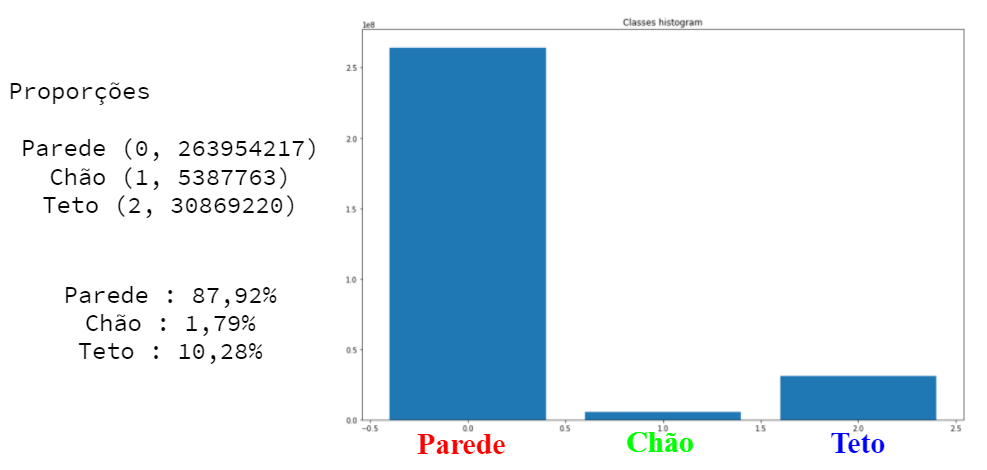

# Criando os datasets Tensorflow (train_dataset, val_dataset e train_dataset)

In [11]:
# Preprocessa as imagens para entrar nas redes.

def prepare_image(rgb_path, seman_path):
    
    #Load images
    rgb_image = tf.io.decode_png(tf.io.read_file(rgb_path), channels=3) # (120,128,3) 
    seman_image = tf.io.decode_png(tf.io.read_file(seman_path), channels=1) # (120,128)

    # Imagens já foram carregadas com resize
    # Imagens semanticas já estão com valores pertencentes a K classes (0,1,2).
    
    # Preprocess
    paddings1= tf.constant([[4, 4], [0, 0], [0,0]]) # Padding images to get 128,128 shape
    paddings2= tf.constant([[4, 4], [0, 0], [0,0]]) # adding 4 pixels on top and down (copy pixels).
    rgb_image = tf.pad(rgb_image, paddings1, "SYMMETRIC") # O padding é simetrico, ou seja copia o pixel do lado.
    seman_image = tf.pad(seman_image, paddings2, "SYMMETRIC")

    # Preprocess images to match vgg16 expected input format.
    rgb_image = tf.keras.applications.vgg16.preprocess_input(rgb_image, data_format=None)

    # One hot encod.
    seman_image = tf.squeeze(seman_image, axis=-1, name=None)
    seman_image = tf.one_hot(seman_image, 3) 

    rgb_image = tf.cast(rgb_image, dtype=tf.float32) 
    seman_image = tf.cast(seman_image, dtype=tf.float32)

    return rgb_image, seman_image

In [12]:
# Função que cria o dataset e divide em pacotes (batch_size).

def generate_dataset(
    rgb_filepaths, 
    seman_filepaths, 
    batch_size=64, 
    shuffle = True
    ):

    # Createas a dataset of filepaths (x and y)
    # Só que esses caminhos vem codificados de forma binaria (b'...',b'...' )
    dataset = tf.data.Dataset.from_tensor_slices((rgb_filepaths, seman_filepaths))  
    # Randomly shuffling input data

    if shuffle:
      dataset = dataset.shuffle(len(rgb_filepaths))
    else:
      pass
    # Produces a new dataset by applying a given function f() to each element of the input dataset --> Creates a dataset of numpy_arrays given the function
    dataset = dataset.map(prepare_image, )          
    dataset = dataset.batch(batch_size)           
    dataset = dataset.prefetch(batch_size)         

    return dataset

In [13]:
# Chama a função que cria os datasets.

train_dataset = generate_dataset(
    x_train,
    y_train,
    shuffle = True
)

val_dataset = generate_dataset(
    x_val,
    y_val
)

test_dataset = generate_dataset(
    x_test,
    y_test,
    shuffle = False # O shuffle aqui é falso pois é o conjunto de treinamento, logo para vermos depois as imagens o não podemos aplicar shuffle.
)

# Tensorflow dataset check

Para conferir informações do dataset e conferir se esta tudo de acordo.

## Função que mostra as informações dos datasets.

In [14]:
import time

def info_dataset(dataset, take_batches=1, info='shape', labels=1 ,idx=0):

    start_time = time.time() # To save runtime.
    for batch, tuple_ in enumerate(dataset):

        if info == 'shape':
            print(tuple_[0].shape, tuple_[1].shape)
        
        elif info == 'len':
            print(len(dataset))

        elif info == 'unique':
          if labels == 0:
            x = input("are u sure? (yes or no)")
            if x == 'yes':
              print(np.unique(tuple_[labels][idx]))
            else:
              pass
          else:
            print(np.unique(tuple_[labels][idx]))

        elif info == 'len_unique':
          if labels == 0:
            x = input("are u sure? (yes or no)")
            if x == 'yes':
              print(len(np.unique(tuple_[labels])))
            else:
              pass
          else:
            print(len(np.unique(tuple_[labels])))

        if batch + 1  == take_batches:
            print('-'*34)
            break

    print(f"Done in {time.time() - start_time} seconds.")

def plot_images_dataset(dataset, idx=0, figsize=(15, 10)):
    for batch, tuple_ in enumerate(dataset):
        if tuple_[1][idx].shape[-1] == 1:
            plot_images(
                [tuple_[0][idx], tf.squeeze(tuple_[1][idx], -1)],
                figsize=figsize,
                subplots_shape=(1, 2),
                cmap='gray')
            pass    
        else:
            plot_images(
                [tuple_[0][idx], tuple_[1][idx]],
                figsize=figsize,
                subplots_shape=(1, 2),
                cmap='gray')
        break

## Visualização

In [15]:
# Comprimento do dataset (quantos batches) 
info_dataset(train_dataset, take_batches=1, info='len')
info_dataset(val_dataset, take_batches=1, info='len')
info_dataset(test_dataset, take_batches=1, info='len')

82
----------------------------------
Done in 0.2608044147491455 seconds.
11
----------------------------------
Done in 0.12343955039978027 seconds.
11
----------------------------------
Done in 0.12299370765686035 seconds.


In [16]:
# Itens por batch:
info_dataset(train_dataset, take_batches=2, info='shape')
info_dataset(val_dataset, take_batches=1, info='shape')
info_dataset(test_dataset, take_batches=1, info='shape')

(64, 128, 128, 3) (64, 128, 128, 3)
(64, 128, 128, 3) (64, 128, 128, 3)
----------------------------------
Done in 0.23244047164916992 seconds.
(64, 128, 128, 3) (64, 128, 128, 3)
----------------------------------
Done in 0.12320852279663086 seconds.
(64, 128, 128, 3) (64, 128, 128, 3)
----------------------------------
Done in 0.12368655204772949 seconds.


In [17]:
# Valores unique
info_dataset(train_dataset, take_batches=1, labels=1 , idx= np.random.randint(0,10), info='unique') # primeira imagem.

[0. 1.]
----------------------------------
Done in 0.13861680030822754 seconds.


In [18]:
# Len Valores unique
info_dataset(train_dataset, take_batches=1, labels=1, info='len_unique')

2
----------------------------------
Done in 0.3185124397277832 seconds.


# U-NET


In [19]:
# Criando uma rede baseada na U-Net

from tensorflow.keras.layers import Conv1D, Conv2D, Dense, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, Input, Reshape, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import L2

n_classes = 3 # Numero de classes.
target_size = (128,128,3) # Tamanho das imagens

pad = 'same'

def conv_block(input, num_filters): # Bloco de convolução caracteristico da rede U-Net.
    x = Conv2D(num_filters, 3, padding=pad)(input)                                                        # 3x3.
    x = BatchNormalization()(x)                                                                           # problema do evaluate pode ser do BatchNormalization.
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding=pad)(x) 
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    return x

def encoder_block(input, num_filters): # Bloco de encoder caracteristico da rede U-Net, realiza a "subida", extração de features.
    x = conv_block(input, num_filters)
    p = MaxPool2D((2, 2))(x)
    return x, p

def decoder_block(input, skip_features, num_filters): # Bloco de decoder caracteristico da rede U-Net, realiza a "descida", reconstrução da imagem semantica.
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding=pad)(input)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

##################

def conv_block_with_reg(input, num_filters): # Bloco convolucional com regularização.

    x = Conv2D(num_filters, 3, padding=pad, kernel_regularizer=L2(l2=0.01))(input)                          # ADD L2.
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Dropout(rate = 0.2)(x)                                                                              ## ADD

    x = Conv2D(num_filters, 3, padding=pad, kernel_regularizer=L2(l2=0.01))(x)                              # ADD L2.
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    return x

def decoder_block_with_reg(input, skip_features, num_filters): # Decoder com regularização.
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding=pad)(input)

    x = Concatenate()([x, skip_features])
    x = conv_block_with_reg(x, num_filters)
    return x

def build_unet(n_classes, input_shape): # Função que constroe a U-Net.
    inputs = Input(input_shape)

    s0, p0 = encoder_block(inputs, 16)
    s1, p1 = encoder_block(p0, 32)
    s2, p2 = encoder_block(p1, 64)
    s3, p3 = encoder_block(p2, 128)
    s4, p4 = encoder_block(p3, 256)
    s5, p5 = encoder_block(p4, 512)

    b1 = conv_block(p5, 1024)

    d1 = decoder_block_with_reg(b1, s5, 512)
    d2 = decoder_block_with_reg(d1, s4, 256)
    d3 = decoder_block_with_reg(d2, s3, 128)
    d4 = decoder_block_with_reg(d3, s2, 64)
    d5 = decoder_block_with_reg(d4, s1, 32)
    d6 = decoder_block_with_reg(d5, s0, 16)

    outputs = Dense(n_classes, activation="sigmoid")(d6) # Sigmoide pois é feita para cada classe separadamente, one-hot encode.

    model = Model(inputs=[inputs], outputs=[outputs], name="U-Net")
    return model

## Chamando a função que cria o modelo da U-Net

In [20]:
xtemp = input('Warning!, Model_unet variable will be replaced, are you sure? (yes, no) ')
if xtemp == 'yes':
  input_shape =  target_size 
  Model_unet = build_unet(n_classes,input_shape)
  Model_unet.summary()
else:
  pass

Warning!, Model_unet variable will be replaced, are you sure? (yes, no) yes
Model: "U-Net"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 16) 448         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 128, 128, 16) 64          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 128, 128, 16) 0           batch_normalization[0][0]        
__________________

# VGG16_U-Net

In [43]:
# Criando uma rede baseada na U-Net com a VGG16 como encoder.

# Começamos importando todas as layers que precisamos:
from tensorflow.keras.layers import Conv2D, Dense, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, Input, Reshape, ZeroPadding2D, Dropout
from tensorflow.keras.regularizers import L2
from tensorflow.keras.models import Model
from keras.applications.vgg16 import VGG16


n_classes = 3 # Numero de classes.
target_size = load_rgb_image(x_train[0]).shape

# Criando os blocos da U-NET: 

# Bloco convolucional:
pad = 'same'
def conv_block(input, num_filters):
    x = Conv2D(num_filters, 3, padding=pad)(input) # 3x3.
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding=pad)(x) 
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    return x

def conv_block_with_reg(input, num_filters):

    x = Conv2D(num_filters, 3, padding=pad, kernel_regularizer=L2(l2=0.001))(input) # ADD L2.
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Dropout(rate = 0.1)(x) ## ADD

    x = Conv2D(num_filters, 3, padding=pad, kernel_regularizer=L2(l2=0.001))(x)  # ADD L2.
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    return x

# Bloco de encoder:
def encoder_block(input, num_filters):
    x = conv_block(input, num_filters)
    p = MaxPool2D((2, 2))(x)
    return x, p

# Bloco de dencoder: Recebe as skip conections e faz a deconvolução.
def decoder_block(input, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding=pad)(input)
    # se um fosse 64 e o outro 32 nao seria uma boa ideia colocar zero padding, porem como é uma camada de 1 pixel, não trara grandes problemas.
    #x = ZeroPadding2D(padding=((1, 0), (0, 0)))(x) # (None, 14, 16, 512) (None, 15, 16, 512) então adicionando um pixel a mais com padding. 
    #print(x.shape, skip_features.shape)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

def decoder_block_with_reg(input, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding=pad)(input)

    x = Concatenate()([x, skip_features])
    x = conv_block_with_reg(x, num_filters)
    return x

def build_vgg_unet(n_classes, input_shape):

    inputs = Input(input_shape) # Primeira entrada da rede, um reshape.

    # Importamos as layers da vgg16, pois iremos utilizar as layers com os pesos já treinados.
    vgg16 = VGG16(input_shape=(128,128,3), weights='imagenet', include_top=False, input_tensor=inputs) # 224x244 (original)

    # Congelando as layers da vgg16
    for layer in vgg16.layers:
	    layer.trainable = False
    #vgg16.summary()
   
    #"Encoder"  Criando as skip conections.

    s1 = vgg16.get_layer("block1_conv2").output #  120, 128, 64
    s2 = vgg16.get_layer("block2_conv2").output #  60, 64, 128
    s3 = vgg16.get_layer("block3_conv3").output #  30, 32, 256
    s4 = vgg16.get_layer("block4_conv3").output #  15, 16, 512

    b1 = vgg16.get_layer("block5_conv3").output #   7, 8, 512

    #"Decoder"

    d1 = decoder_block(b1, s4, 512) 
    d2 = decoder_block_with_reg(d1, s3, 256) # Adicionado regularização.
    d3 = decoder_block(d2, s2, 128) 
    d4 = decoder_block_with_reg(d3, s1, 64)  # Adicionado regularização.

    "Outputs"
    outputs = Dense(n_classes, activation="sigmoid")(d4)

    model = Model(inputs=[inputs], outputs=[outputs], name="Vgg_U-Net_with_reg")
    return model
   

## Chamando a função que cria o modelo da U-Net VGG16.

In [44]:
xtemp = input('Warning!, Model_vgg16_unet variable will be replaced, are you sure? (yes, no)')
if xtemp == 'yes':
  Model_vgg16_unet_with_reg = build_vgg_unet(n_classes,(128,128,3)) # Model_vgg16_unet
  Model_vgg16_unet_with_reg.summary()
else:
  pass

Warning!, Model_vgg16_unet variable will be replaced, are you sure? (yes, no)yes
Model: "Vgg_U-Net_with_reg"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 128, 128, 64) 1792        input_3[0][0]                    
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 128, 128, 64) 36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, 64, 64, 64)   0           block1_conv2[0][0]               


# Carregando o Tensorboard para analisar o resultado do treinamento

In [24]:
# Clear any logs from previous runs (executada no terminal)
%rm -rf ./logs/ 

# Importando o tensorboard.
from tensorflow.keras.callbacks import TensorBoard
import datetime
# Coloque os registros em um subdiretório com carimbo de data / hora para permitir a fácil seleção de diferentes execuções de treinamento.
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
# habilite o cálculo do histograma a cada época com histogram_freq=1 (desativado por padrão).
tensorboard_cb = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1) # Cria um callback.

# Habilitando a extenção do tensorboard
%tensorflow_version 2.x 
# Não pode ter comentario do lado... ; carregando o tensorboard.
%load_ext tensorboard  

# Definindo uma função linear para o decaimento do learning rate (learningschedule function)

In [25]:
# Definindo uma função para o decaimento da taxa de aprendizado.

def schedule(epoch, lr):
  if epochs < warmup_epochs:
    return lrmax*(epoch + 1)/(warmup_epochs + 1)
  return lrmax*(1 - (epoch - warmup_epochs)/(epochs - warmup_epochs))

# Opicional

## Criando diretorio e callback para salvamento automatico do modelo

In [ ]:
# Criando diretorio e callback para salvamento do modelo.

checkpoint_path = "training_1/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

# Loads the weights
#model.load_weights(checkpoint_path)

## Usar a cpu para carregar proximo batch de imagens, enquanto a GPU processa um batch, a CPU já prepara (resize) e carrega outro na memoria.



In [26]:
Autotunning = 3
# buffer_size é em numero de bachs.
train_dataset = train_dataset.prefetch(buffer_size=Autotunning) # guarda img na cache train_ds.cache() , batch(batch_size) junta um bacth.
val_dataset = val_dataset.prefetch(buffer_size=Autotunning) # prefetch(buffer_size=10) guarda na memoria da GPU (10 batch).
test_dataset = test_dataset.prefetch(buffer_size=Autotunning)

# Definindo as funções de metricas e perdas

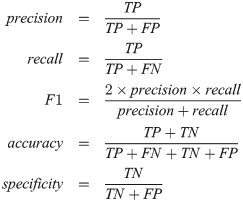

In [27]:
from tensorflow.keras import backend as K

smooth = 1e-15 # Para suavilização da metrica.

# Precission: TP / (TP + FP)

# Recall: TP / (TP + FN)

# Precisão: dentre todas as classificações de classe Positivo que o modelo fez, 
# quantas estão corretas; 

# Recall/Revocação/Sensibilidade: 
# Dentre todas as situações de classe Positivo como valor esperado,
# quantas estão corretas; 
 
# F1-Score: Média harmônica entre precisão e recall = dice.

######################################################################################################

def dice_coef(y_true, y_pred):                      
    y_true = tf.keras.layers.Flatten()(y_true)
    y_pred = tf.keras.layers.Flatten()(y_pred)
    intersection = tf.reduce_sum(y_true * y_pred)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)  #  2xIntersection / (union + intersection)

def dice_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred)

######################################################################################################

def iou(y_true, y_pred):                      
    y_true = tf.keras.layers.Flatten()(y_true)
    y_pred = tf.keras.layers.Flatten()(y_pred)
    intersection = tf.reduce_sum(y_true * y_pred) # Intersection
    return ( intersection / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - intersection) )

def iou_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred)

######################################################################################################

def soft_dice_coef(y_true, y_pred):                      
    y_true = tf.keras.layers.Flatten()(y_true)
    y_pred = tf.keras.layers.Flatten()(y_pred)
    intersection = tf.reduce_sum(y_true * y_pred)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true**2) + tf.reduce_sum(y_pred**2) + smooth) 

######################################################################################################
# IoU para multiclasse (Tirando a média).

def mean_iou(y_true, y_pred):        
    iou_ = 0
    numLabels=3

    for index in range(numLabels):  
      iou_ = iou_ + iou(y_true[:,:,:,index], y_pred[:,:,:,index])
    return iou_/numLabels

def mean_iou_loss(y_true, y_pred):
    return 1.0 - mean_iou(y_true, y_pred)

######################################################################################################
# Dice para multiclasse (Tirando a média).

def dice_coef_multilabel(y_true, y_pred): # y_pred_th = cv.threshold(y_pred, .5, 1, cv.THRESH_BINARY)[1] 
    dice=0
    numLabels=3
    for index in range(numLabels):
        dice = dice + dice_coef(y_true[:,:,:,index], y_pred[:,:,:,index])
    return dice/numLabels # taking average

def dice_coef_mult_loss(y_true, y_pred):
    return 1.0 - dice_coef_multilabel(y_true, y_pred)

######################################################################################################
# Soft Dice para multiclasse (Tirando a média).

def soft_dice_coef_multilabel(y_true, y_pred): # y_pred_th = cv.threshold(y_pred, .5, 1, cv.THRESH_BINARY)[1] 
    dice=0
    numLabels=3

    #y_pred_th = cv.threshold(y_pred, .5, 1, cv.THRESH_BINARY)[1]

    for index in range(numLabels):
        dice = dice + soft_dice_coef(y_true[:,:,:,index], y_pred[:,:,:,index])
    return dice/numLabels # taking average

def soft_dice_coef_mult_loss(y_true, y_pred):
    dice=0
    numLabels=3

    for index in range(numLabels):
        dice = dice + soft_dice_coef(y_true[:,:,:,index], y_pred[:,:,:,index])
    return 1.0 - (dice/numLabels)

######################################################################################################
# Soft Dice multiclasse com ponderação.

def soft_dice_coef_mult_pond(y_true, y_pred):
    dice=0
    pesos = [1,1,1] # 0 wall, 1 floor, 2 roof (numLabels)

    for index, peso in zip(np.arange(len(pesos)), pesos):
        dice = dice + (peso * soft_dice_coef(y_true[:,:,:,index], y_pred[:,:,:,index]))
    return dice/len(pesos) # taking average

def soft_dice_coef_mult_pond_loss(y_true, y_pred):
    return 1.0 - soft_dice_coef_mult_pond(y_true, y_pred)

# Definindo parametros e compilando o modelo

In [28]:
# Adicionando Early Stopping.
from keras.callbacks import EarlyStopping
# Adicionando Learning Rate Scheduler.
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.optimizers import Adam, Adadelta

opt = Adam(learning_rate = 0.0001)
es_cb = EarlyStopping(monitor='val_soft_dice_coef_multilabel', mode='max', patience=50, verbose=0)


In [45]:
from tensorflow.keras.metrics import Recall, Precision
from tensorflow.keras.metrics import Accuracy, BinaryAccuracy, Precision, MeanIoU, Recall, RecallAtPrecision

# Carregando um modelo para treinar, (Model_vgg16_unet, Model_vgg16_unet, Model_vgg16_unet_with_reg, Model_unet ou model_loaded).

xconf = input("Warning!, model will be replaced, are you sure? (yes, no) ")

if xconf == 'yes':
  model = Model_vgg16_unet_with_reg 

  # Compilando o modelo.
  metrics = [soft_dice_coef_multilabel, mean_iou, 'accuracy'] # Metricas para avaliação.
  model.compile(optimizer=opt , loss = soft_dice_coef_mult_loss, metrics=metrics) 

else:
  pass

Warning!, model will be replaced, are you sure? (yes, no) yes


# Descongelando as camadas do modelo (Quando aplicavel)

In [ ]:
# Caso queira descongelar as camadas do modelo.

model.trainable = True

model.summary()

# Treinando o modelo

In [ ]:
# Training 

epochs = 2
warmup_epochs = 0.1*epochs
lrmax = 0.02
schedule_cb = LearningRateScheduler(schedule, verbose=0) 

history1 = model.fit(train_dataset, 
                     epochs=epochs, 
                     verbose=2,
                     validation_data = val_dataset,
                     callbacks=[es_cb, tensorboard_cb, schedule_cb]) 

# ###########################################################
# # Save the entire model as a SavedModel.

# Models_folder = '/content/drive/MyDrive/Models/'

# try:
#   model.save(os.path.join(Models_folder, "U_net_soft_3classes.h5")) 
#   print("Modelo salvo com sucesso")
# except:
#   print("Erro no salvamento do modelo.")
# ###########################################################

In [ ]:
# Avaliando o desenpenho do modelo.

model.evaluate(train_dataset)
model.evaluate(val_dataset)
model.evaluate(test_dataset)

# Carregando logs do tensorboard


In [ ]:
%tensorboard --logdir logs

#Visualizando as predições realizadas

In [49]:
y_pred = model.predict(test_dataset) # Realizando predições no conjunto de testes.

In [ ]:
# Visualização das predições realizada no conjunto de testes.

from ipywidgets import interact
from sklearn.metrics import matthews_corrcoef
# x_ = x_train
# y_ = y_train

x_ = x_test
y_ = y_test

@interact(key = (0,len(x_)-1))

def _(key = 0):

  plt.subplots(figsize = (15,15))
  plt.subplot(1,3,1)
  plt.title("RGB Input")
  plt.imshow(load_rgb_image(x_[key]))

  plt.subplot(1,3,2)

  # print('y_pred',(y_pred[key,...]).shape)
  
  y_pred_th = cv.threshold(y_pred[key,...], .5, 1, cv.THRESH_BINARY)[1] # Realizando o threshold antes de aplicar as metricas.

  plt.title("Prediction")
  plt.imshow( np.moveaxis( np.array( [y_pred_th[...,0] , y_pred_th[...,1] ,  y_pred_th[...,2] ] ), 0, -1) )

  plt.subplot(1,3,3)

  xx, yy = prepare_image(x_[key], y_[key])
  plt.title("Mask")
  plt.imshow( np.moveaxis( np.array( [yy[...,0], yy[...,1], yy[...,2] ] ), 0, -1 ))

  # print('y_pred_th ',y_pred_th.shape)
  # plt.subplots(figsize = (15,15))
  # plt.subplot(1,3,1)
  # plt.imshow(y_pred_th[...,0], cmap = 'gray')
  # print('wall',np.unique(y_pred_th[...,0]))
  # plt.subplot(1,3,2)
  # plt.imshow(y_pred_th[...,1], cmap = 'gray')
  # print('floor',np.unique(y_pred_th[...,1]))  
  # plt.subplot(1,3,3)
  # print('roof',np.unique(y_pred_th[...,2]))
  # plt.imshow(y_pred_th[...,2], cmap = 'gray')

  print(f'soft_dice_coef_multilabel: {soft_dice_coef_multilabel(np.expand_dims( yy, 0 ) , np.expand_dims( y_pred_th, 0 ))}')
  print(f'mean_iou: {mean_iou(np.expand_dims( yy, 0 ) , np.expand_dims( y_pred_th, 0 ))}')

  print(f'matthews_corrcoef: {matthews_corrcoef(yy.numpy().flatten(), y_pred_th.flatten())}')

# Salvando e carregando modelos

In [ ]:
# Salvando o modelo:

# Save the entire model as a SavedModel.

Models_folder = '/content/drive/MyDrive/Models/'

model.save(os.path.join(Models_folder, "Soft_dice_vgg16_3classes_model_98-95-95.h5"))

In [ ]:
# Carrega o modelo

model_name = 'Soft_dice_vgg16_3classes_98-95-95' # Soft_dice_vgg16_3classes_93-92-93 # Soft_dice_U_net_with_reg_3classes_97-91-90 # Soft_dice_vgg16_3classes_98-95-95

model_loaded_dir = '/content/drive/MyDrive/Models/' + str(model_name) +'.h5'

# Quando carregamos o modelo, devemos passar os custom_objects caso tenhamos utilizados uma metrica e função perda diferente.
model_loaded = tf.keras.models.load_model(model_loaded_dir , custom_objects= {'soft_dice_coef_mult_loss': soft_dice_coef_mult_loss, 'soft_dice_coef_multilabel': soft_dice_coef_multilabel, 'mean_iou': mean_iou, 'mean_iou_loss': mean_iou_loss} , compile= True) # if only inference, compile can be false.

#model_loaded.summary()


# Analisando o desempenho em datasets Reais


In [38]:
# Baixando o arquivo rar que contem o dataset para o colab. 
%cp -r /content/drive/MyDrive/Datasets/rgb_real_resized_home /content/

%cd "/content/rgb_real_resized_home" 

/content/rgb_real_resized_home


In [39]:
# Descompactando os arquivos.

direc = "/content/rgb_real_resized_home"

x_real_data = load_files_from_dir(direc, max_ = None)

10 directories successful loaded.


In [ ]:
# Realizando predições nas imagens reais

#OBS: ANTES É NECESSARIO CARREGAR O MODELO (model_loaded).

model_loaded = model

@interact(key = (0,len(x_real_data)-1))

def _(key = 0):

  paddingg= tf.constant([[4, 4], [0, 0], [0,0]]) # adding 4 pixels on top and down (copy pixels).

  teste_image = tf.pad(load_rgb_image(x_real_data[key]), paddingg, "SYMMETRIC")

  teste_image = tf.keras.applications.vgg16.preprocess_input(teste_image, data_format=None)

  teste_image = rgb_image = tf.cast(teste_image, dtype=tf.float32)

  y_real_pred = model_loaded.predict( np.expand_dims( teste_image , 0)  )

  plt.subplots(figsize = (15,15))

  plt.subplot(1,3,1)
  plt.title("rgb image")
  plt.imshow(load_rgb_image(x_real_data[key]))

  plt.subplot(1,3,2)

  y_real_pred_th = cv.threshold(y_real_pred[0,...], .5, 1, cv.THRESH_BINARY)[1] 

  #plt.imshow( np.moveaxis( np.array( [y_pred_th[...,0],y_pred_th[...,1],y_pred_th[...,2] + y_pred_th[...,3] ] ), 0, -1 )) 
  plt.title("Prediction")

  plt.imshow( np.moveaxis( np.array( [y_real_pred_th[...,0] , y_real_pred_th[...,1] ,  y_real_pred_th[...,2] ] ), 0, -1) )

# Outros

## Pipeline pre prossecessamento (Antes de carregar as imagens (dataset) para o drive)

In [ ]:
import numpy as np
import os 
import cv2 as cv
import shutil as sh
import time
from matplotlib import pyplot as plt
from os import listdir

from matplotlib import image

# Re-mapear para as n_classes mais frequentes (Reduzir problema e rebalancear)

new_map_dic = {(0, 0, 0): 0, 
    (174, 199, 232): 1,
    (152, 223, 138): 2,
    (31, 119, 180): 3,
    (255, 187, 120): 4,
    (188, 189, 34): 5,
    (140, 86, 75): 6,
    (255, 152, 150): 7,
    (214, 39, 40): 8,
    (197, 176, 213): 9,
    (148, 103, 189): 11,
    (196, 156, 148): 1,
    (23, 190, 207): 7,
    (178, 76, 76): 11,
    (247, 182, 210): 11,
    (66, 188, 102): 11, 
    (219, 219, 141): 1,
    (140, 57, 197): 7, 
    (202, 185, 52): 4, 
    (51, 176, 203): 1, 
    (200, 54, 131): 11, 
    (92, 193, 61): 11,
    (78, 71, 183): 10,
    (172, 114, 82): 11, 
    (255, 127, 14): 3,
    (91, 163, 138): 1, 
    (153, 98, 156): 11, 
    (140, 153, 101): 11,
    (158, 218, 229): 11,
    (100, 125, 154): 1,
    (178, 127, 135): 11,
    (120, 185, 128): 11,
    (146, 111, 194): 7,
    (44, 160, 44): 11,
    (112, 128, 144): 1,
    (96, 207, 209): 10, 
    (227, 119, 194): 11,
    (213, 92, 176): 11, 
    (94, 106, 211): 1, 
    (82, 84, 163): 11,
    (100, 85, 144): 1 
    }

def load_imagens(dir_, max_ = None, return_names = False):
    
    """
    dir_ -> Main directory of images. (ex: //folder//my_files_to_load)).
    max -> Num of images to load. (If nome, loads all.)
    if return_names = True -> return img_list, image_names
    else, return img_list
    """
    
    img_list = []
    image_names = []
    
    if max_ == None:
        max_ = len(listdir(dir_))
        
    for filename in sorted(listdir(dir_))[0:max_]:
        img_data = image.imread(dir_ + '/' + filename) # load image.
        ##img_data = cv.cvtColor(img_data, cv.COLOR_BGR2RGB) # convert to RGB.
        image_names.append(filename) # store the name of the image (if you wish).
        img_list.append(img_data) # store loaded image.
        ##print('> loaded %s %s' % (filename, img_data.shape)).
    print(f'{len(image_names)} images successful loaded.')
    if return_names:
        return img_list, image_names
    else:
        return img_list
    
print('Carregando imagens...')
semantic_15, semantic_15_names = load_imagens("C:\\Users\\vinc\\Desktop\\Structured3D_rgb_semantic_15_resized\\semantic_resized", max_ = None, return_names = True)
semantic_16, semantic_16_names = load_imagens("C:\\Users\\vinc\\Desktop\\Structured3D_rgb_semantic_16_resized\\semantic_resized", max_ = None, return_names = True)
semantic_17, semantic_17_names = load_imagens("C:\\Users\\vinc\\Desktop\\Structured3D_rgb_semantic_17_resized\\semantic_resized", max_ = None, return_names = True)

Dataset_semantic = semantic_15 + semantic_16 + semantic_17
Dataset_names = semantic_15_names + semantic_16_names + semantic_17_names

del semantic_15
del semantic_16
del semantic_17

def map_image_to_classes_fast(tomap_image_list, class_dict):

    start_time = time.time()
    mapped_image_list = [] # 

    for image in tomap_image_list:

        image_map = np.zeros((image.shape[0],image.shape[1]))

        for rgb_pixel in class_dict:
            rgb_pixel = rgb_pixel
            class_value = class_dict[rgb_pixel] # get the class ID. 
            #tuple_ = np.where(image == rgb_pixel) # Get index of rgb value. (0,10,20)                     

            indices = np.where(np.all(255*image == rgb_pixel, axis=-1))

            listOfCoordinates = list(zip(indices[0], indices[1])) # append.

            for index in listOfCoordinates: # For index in list:
                image_map[index] = class_value # fill the image_map with the class_value.
            listOfCoordinates.clear() # Clear list.

        mapped_image_list.append(image_map)
        
    print(f"Done in {time.time() - start_time} seconds.")
    return mapped_image_list

print('Mapeando classes...')
Dataset_semantic_new_mapped = map_image_to_classes_fast(tomap_image_list = Dataset_semantic, class_dict = new_map_dic)

del Dataset_semantic

def save_images_on_disk(image_list, dir_to_save, format_ = "png" , image_names_list = None , foldername = 'saved_images'):
    """
    Create a folder in dir_to_save and save the list of images on disk.

    image_list -> List of images to save (waiting normalized images [0 to 1]).
    dir_to_save -> Directorie to save images.
    format_ -> Format of the image, png, jpeg.
    image_names_list -> List of name of images if you wish, like: [image_name, another_image_name].
    foldername -> Name of the folder to create, if already exists, then will save there.
    """

    start_time = time.time() # To save runtime.

    new_dir = os.path.join(dir_to_save , foldername) # Creates directorie name (to save).
    #new_dir = dir_to_save +'\\'+ foldername # Creates directorie name (to save).
    try:
        os.mkdir(os.path.join(dir_to_save, foldername)) # Creates directorie to store images.
    except:
        pass

    if image_names_list == None: # Creates the name of the images.
        image_names_list = np.arange(0,len(image_list))

    for i , image in enumerate(image_list):
        if image_names_list is None:
            file_dir = (os.path.join(new_dir , "image" + str(image_names_list[i])) + "." + format_)
        else:
            file_dir = (os.path.join(new_dir , image_names_list[i]))
        cv.imwrite(file_dir , image)
    print(f'{len(image_list)} images saved to disk')
    print(f"Done in {time.time() - start_time} seconds.")

dir_seg_images = 'C:\\Users\\vinc\\Desktop\\Structured3D_151617_preprocessed2'

print('Salvando novas imagens no disco...')
save_images_on_disk(Dataset_semantic_new_mapped, dir_to_save = dir_seg_images, format_ = "png" , image_names_list = Dataset_names, foldername = 'semantic_preprocessed_3classes')

## U-Net VGG16 sem regularização.

In [ ]:
# Creating vgg net up.

# ver pre processamento da vgg

# Começamos importando todas as layers que precisamos:
from tensorflow.keras.layers import Conv2D, Dense, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, Input, Reshape, ZeroPadding2D, Dropout
from tensorflow.keras.regularizers import L2
from tensorflow.keras.models import Model
from keras.applications.vgg16 import VGG16

"""# Make the loaded layers non trainable.
for layer in VGG_model.layers:
	layer.trainable = False"""

n_classes = 3 
target_size = load_image(x_train[0]).shape

# Criando os blocos da U-NET: 

# Bloco convolucional:
pad = 'same'
def conv_block(input, num_filters):
    x = Conv2D(num_filters, 3, padding=pad)(input) # 3x3.
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding=pad)(x) 
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    return x

# Bloco de encoder:
def encoder_block(input, num_filters):
    x = conv_block(input, num_filters)
    p = MaxPool2D((2, 2))(x)
    return x, p

# Bloco de dencoder: Recebe as skip conections e faz a deconvolução.
def decoder_block(input, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding=pad)(input)
    # se um fosse 64 e o outro 32 nao seria uma boa ideia colocar zero padding, porem como é uma camada de 1 pixel, não trara grandes problemas.
    #x = ZeroPadding2D(padding=((1, 0), (0, 0)))(x) # (None, 14, 16, 512) (None, 15, 16, 512) então adicionando um pixel a mais com padding. 
    #print(x.shape, skip_features.shape)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

def build_vgg_unet(n_classes, input_shape):

    inputs = Input(input_shape) # Primeira entrada da rede, um reshape.

    # Importamos as layers da vgg16, pois iremos utilizar as layers com os pesos já treinados.
    vgg16 = VGG16(input_shape=(128,128,3), weights='imagenet', include_top=False, input_tensor=inputs) # 224x244 (original)


    # Congelando as layers da vgg16
    for layer in vgg16.layers:
	    layer.trainable = False
    #vgg16.summary()
   
    
    #"Encoder"  Criando as skip conections.
    s1 = vgg16.get_layer("block1_conv2").output #  120, 128, 64
    s2 = vgg16.get_layer("block2_conv2").output #  60, 64, 128
    s3 = vgg16.get_layer("block3_conv3").output #  30, 32, 256
    s4 = vgg16.get_layer("block4_conv3").output #  15, 16, 512

    b1 = vgg16.get_layer("block5_conv3").output #   7, 8, 512

    #"Decoder"

    d1 = decoder_block(b1, s4, 512) 
    d2 = decoder_block(d1, s3, 256) 
    d3 = decoder_block(d2, s2, 128) 
    d4 = decoder_block(d3, s1, 64) 

    "Outputs"
    outputs = Dense(n_classes, activation="sigmoid")(d4)

    model = Model(inputs=[inputs], outputs=[outputs], name="Vgg_U-Net")
    return model